### Notebook that generates figures used for paper

In [1]:
import os

os.environ["USE_PYGEOS"] = "0"
import json
import geopandas
import pandas
import numpy
import shapely
from shapely.geometry import Point, Polygon
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams
import seaborn as sns
from palettable.cartocolors.qualitative import Bold_6
import contextily as cx

Set default plotting themes/parameters and add color dictionary for continents.

In [17]:
rcParams.update({"figure.autolayout": True})

mypalette = Bold_6.hex_colors

sns.set_theme(
    context="paper",
    style="ticks",
    rc={
        "patch.force_edgecolor": False,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
    },
    palette=mypalette,
)

coldict = {
    "Africa": 0,
    "Asia": 1,
    "Europe": 2,
    "North America": 3,
    "Oceania": 4,
    "South America": 5,
}

Subfolders for plots

In [3]:
mydirs = ["../plots/paper/"]

for mydir in mydirs:
    os.makedirs(mydir, exist_ok=True)

Load metadata

In [4]:
sample = geopandas.read_parquet("../data/sample.parquet")
sample["eFUA_ID"] = sample.apply(lambda x: int(x.eFUA_ID), axis=1)

In [14]:
cities_for_validation = [
    "Abidjan",
    "Conakry",
    "Douala",
    "Mogadishu",  # Africa
    "Aleppo",
    "Kabul",
    "Semarang",
    "Seoul",  # Asia
    "Bucaramanga",
    "Porto Alegre",  # South America
    "Cincinnati",
    "Dallas",
    "Ottawa",
    "Raleigh",
    "Richmond",
    "Río Piedras [San Juan]",
    "Salt Lake City",
    "San Jose",
    "Washington D.C.",  # North America
    "Auckland",  # Oceania
    "Amsterdam",
    "Belgrade",
    "Chelyabinsk",
    "Helsinki",
    "Katowice",
    "Krakow",
    "Liège",
    "Nuremberg",
    "Saratov",
    "Vienna",
    "Warsaw",  # Europe
]

sample_validation = sample[sample.eFUA_name.isin(cities_for_validation)]

***
***
**Figure 1** 

Zoom-in plots of detected graph face artifacts

- play with 2 colors from list of 6 that we already use
- make subplots showcasing different examples (roundabout, highway, tram stop?, river)
- (possibly) from different cities
- try highlighting only artifacts
- (ignore for now - find a different background map later maybe)

In [139]:
# # define city (by its eFUA_name)
# my_city = "Vienna"

# # get its eFUA ID
# my_id = sample[sample["eFUA_name"] == my_city]["eFUA_ID"].values[0]

# # get threshold
# my_threshold = results[my_city]["circular_compactness_index"]["threshold"]
# my_threshold += 0

# # get polygon data and project to given crs
# fua = all_poly_data[all_poly_data.name == my_city]
# fua = fua.set_crs(crs_dict[my_id])

# # define a subplot for this city:
# # manual def of bounding box by finding a nice spot on the map,
# xmin, ymin = 601843.4, 5336442.0  # lower left
# xmax, ymax = 602531.0, 5336992.9  # upper right

# my_box = geopandas.GeoDataFrame(
#     {
#         "geometry": [
#             Polygon(
#                 [
#                     Point(xmin, ymin),
#                     Point(xmin, ymax),
#                     Point(xmax, ymax),
#                     Point(xmax, ymin),
#                 ]
#             )
#         ]
#     },
#     crs=crs_dict[my_id],
# )

# # clip geometries to box
# fua = fua.clip(my_box)

# # get street edge data, also clipped
# edges = geopandas.read_parquet(f"../data/{my_id}/roads_osm.parquet").clip(my_box)

# # initialize plot
# fig, ax = plt.subplots(1, 1)

# # add face artifacts
# fua[fua["circular_compactness_index"] <= threshold].plot(ax=ax, alpha=0.3, color="red")

# # add true urban blocks
# fua[fua["circular_compactness_index"] > threshold].plot(ax=ax, alpha=0.3, color="blue")

# # add street edges
# edges.plot(ax=ax, color="black")

# # add basemap
# cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Voyager, crs=fua.crs)

# # no axis
# ax.set_axis_off()

# plt.show()

***
***
**Figure 4: Evaluation**
- percentage of identified T's for each Si
- valley and left peak - strength
- computational power


In [5]:
# load peak results
results = json.load(open("../results/04_peaks_results.json"))

# load parameters (metric names)
options = [
    "circular_compactness_index",
    "isoperimetric_quotient_index",
    "isoareal_quotient_index",
    "radii_ratio_index",
    "diameter_ratio_index",
]

option_labels = [opt.replace("_", " ").replace("index", "") for opt in options]

# load comp perform results
perf = pandas.read_csv("../results/performance.csv", index_col=0)
perf.columns = [c.replace("_", " ") for c in perf.columns]

In [6]:
# figure settings and init
rcParams.update({"figure.autolayout": True})
mybarwidth = 0.5
mypalette = Bold_6.hex_colors

/var/folders/b0/lkvf88hn0673f5dlj9z0_2dr0000gn/T/ipykernel_26477/270248601.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(option_labels, rotation=90)
100%|██████████| 31/31 [00:03<00:00,  7.80it/s]


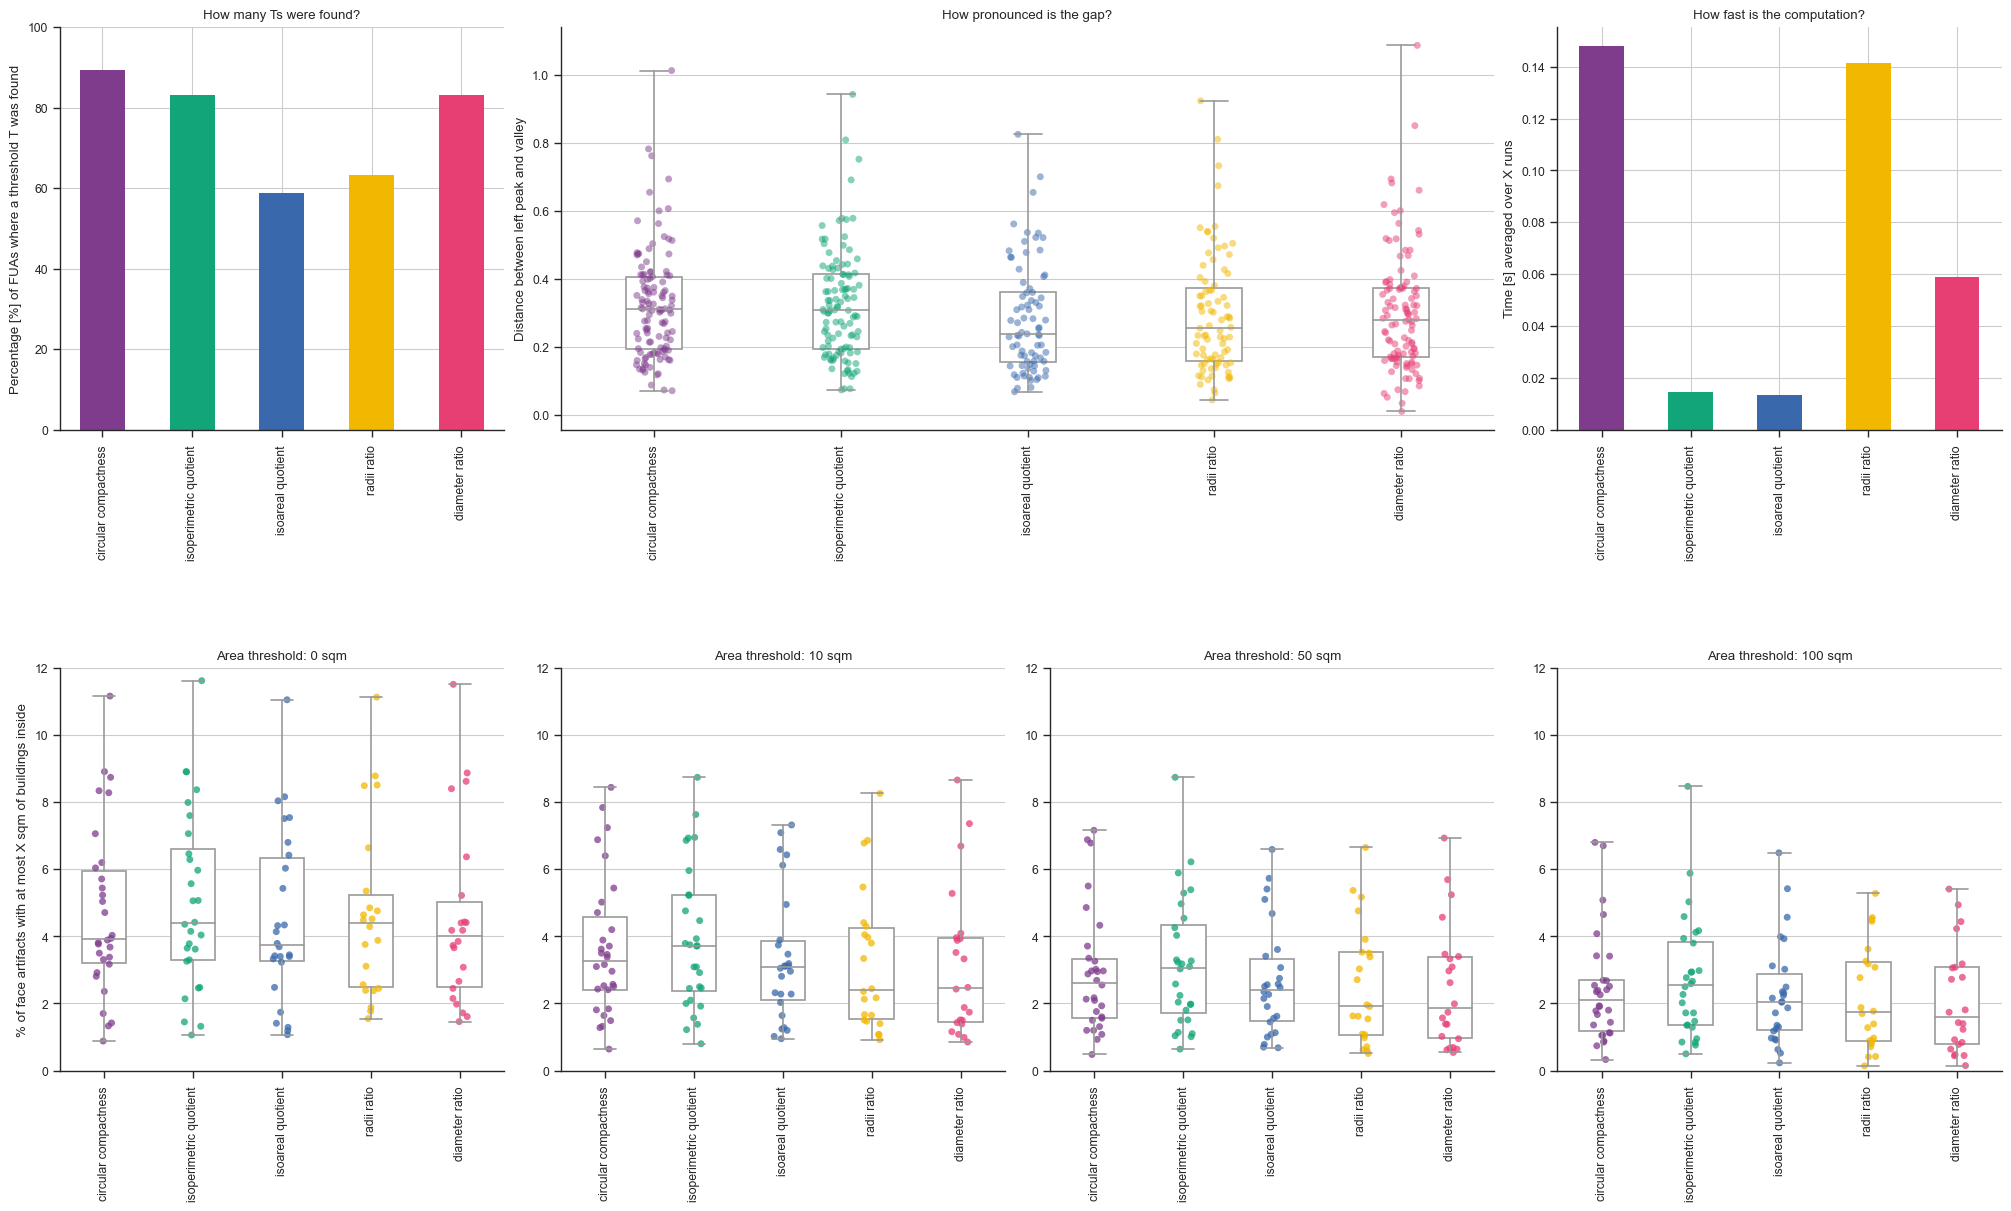

In [33]:
fig = plt.figure(layout="constrained", figsize=(20,12))

# set up grid
gs = GridSpec(2, 4, figure=fig, hspace = .15)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1:3])
ax3 = fig.add_subplot(gs[0,3])
ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[1,2])
ax7 = fig.add_subplot(gs[1,3])

# Subplot1: Comparison of metrics: what percentage of thresholds could be found?
thresholds_found = [
    sum([results[city][option]["threshold"] != False for city in results.keys()])
    for option in options
]
thresholds_found_pct = [100 * t / len(results.keys()) for t in thresholds_found]

ax1.bar(
    x=option_labels, 
    height=thresholds_found_pct, 
    width=mybarwidth,
    color = mypalette[0:5])
ax1.set_ylim((0, 100))
ax1.set_xticklabels(option_labels, rotation=90)
ax1.set_ylabel("Percentage [%] of FUAs where a threshold T was found")
ax1.set_title("How many Ts were found?")


# Subplot2: How pronounced is the valley/peak?

ax2.set_title("How pronounced is the gap?")

# prepare data
df = pandas.DataFrame()
df["Continent"] = [sample.loc[sample["eFUA_name"]==city, "continent"].values[0] for city in results.keys()]
for option in options:
    y_diff_left = []
    for city in results.keys():
        if results[city][option]["threshold"] != False:
            y_diff_left.append(
                results[city][option]["y_diff_max"]
                )
        else:
            y_diff_left.append("nan")
    df["ydiffleft_"+option] = y_diff_left
df = pandas.melt(df, "Continent")
df.drop(numpy.where(df.value == "nan")[0], axis = 0, inplace = True)

# plot
sns.boxplot(
    ax=ax2, 
    data = df,
    x = "variable", 
    y = "value",
    whis=[0, 100], 
    width=.3,
    color="white",
    saturation = 0.2,
)
sns.stripplot(
    ax=ax2,
    data = df, 
    x = "variable",
    y = "value", 
    hue = "variable",
    dodge = False, 
    alpha = 0.5, 
    zorder = 1, 
    legend = False,
    palette = mypalette[0:5]
    );
ax2.set_ylabel("Distance between left peak and valley");
ax2.set_xlabel("")
ax2.set_xticklabels(option_labels, rotation=90)

# Subplot3: computational performance
ax3.set_title("How fast is the computation?")
means = perf.mean()
means.plot.bar(
    ax=ax3,
    color=mypalette[0:5]
    )
ax3.set_ylabel("Time [s] averaged over X runs")
ax3.set_xticklabels(option_labels, rotation=90)

# plt.suptitle("Evaluation: Which compactness metric to use?")

# Subplots 4-7: false positive percentages for different area thresholds

subax = [ax4, ax5, ax6, ax7]
for i, area_threshold in enumerate([0,10,50,100]):
    df_cities, df_options, df_fps = [], [], []
    for ix, row in tqdm(sample_validation.iterrows(), total=len(sample_validation)):
        city = row.eFUA_name
        myid = row.eFUA_ID
        polygons = geopandas.read_parquet(f"../data/{int(myid)}/polygons/")
        for option in options:
            threshold = results[city][option]["threshold"]
            nr_tot = len(polygons)
            nr_art = len(polygons[polygons[option]<threshold])
            if nr_art > 0:
                nr_fp = len(polygons[(polygons[option]<threshold) & (polygons["intersection_area"]>area_threshold)])
                pct_fp = numpy.round(100*nr_fp/nr_art, 2)
            else: 
                pct_fp = "nan"
            df_cities.append(city)
            df_options.append(option)
            df_fps.append(pct_fp)
        df = pandas.DataFrame()
        df["city"] = df_cities
        df["option"] = df_options
        df["pct_fp"] = df_fps
        df.drop(numpy.where(df.pct_fp == "nan")[0], axis = 0, inplace = True)
        df.drop(df[df["city"]=="Mogadishu"].index, axis = 0, inplace = True)
    sns.boxplot(
        ax=subax[i], 
        data = df,
        x = "option", 
        y = "pct_fp",
        whis=[0, 100], 
        width=.5,
        color="white",
        saturation = 0.2,
    )
    sns.stripplot(
        ax=subax[i],
        data = df, 
        x = "option",
        y = "pct_fp", 
        hue = "option",
        dodge = False, 
        alpha = 0.75, 
        zorder = 1, 
        legend=False,
        palette=mypalette[0:5]
        );

    subax[i].set_xticklabels(option_labels, rotation=90)
    subax[i].set_ylim(ymin = 0, ymax = 12)
    subax[i].set_xlabel("")
    subax[i].set_title(f"Area threshold: {area_threshold} sqm")
    subax[i].set_ylabel("") # override seaborn's automatic labelling
subax[0].set_ylabel("% of face artifacts with at most X sqm of buildings inside")

plt.show()
fig.savefig("../plots/paper/eval.png", dpi = 300, bbox_inches = "tight")

In [32]:
# fig, ax = plt.subplots(1,3, figsize = (20,6))

# # first figure: Comparison of metrics: what percentage of thresholds could be found?
# i = 0
# thresholds_found = [
#     sum([results[city][option]["threshold"] != False for city in results.keys()])
#     for option in options
# ]
# thresholds_found_pct = [100 * t / len(results.keys()) for t in thresholds_found]

# ax[i].bar(
#     x=option_labels, 
#     height=thresholds_found_pct, 
#     width=mybarwidth,
#     color = mypalette)
# ax[i].set_ylim((0, 100))
# ax[i].set_xticklabels(option_labels, rotation=90)
# #ax[i].set_xlabel("Shape metric")
# ax[i].set_ylabel("Percentage [%] of thresholds T found")
# ax[i].set_title("How many Ts were found?")

# # second figure:
# i = 1
# ax[i].set_title("How pronounced is the gap?")

# # prepare data
# df = pandas.DataFrame()
# df["Continent"] = [sample.loc[sample["eFUA_name"]==city, "continent"].values[0] for city in results.keys()]
# for option in options:
#     y_diff_left = []
#     for city in results.keys():
#         if results[city][option]["threshold"] != False:
#             y_diff_left.append(
#                 results[city][option]["y_diff_max"]
#                 )
#         else:
#             y_diff_left.append("nan")
#     df["ydiffleft_"+option] = y_diff_left
# df = pandas.melt(df, "Continent")
# df.drop(numpy.where(df.value == "nan")[0], axis = 0, inplace = True)

# # plot
# sns.boxplot(
#     ax=ax[i], 
#     data = df,
#     x = "variable", 
#     y = "value",
#     whis=[0, 100], 
#     width=.5,
#     color="white",
#     saturation = 0.2,
# )
# sns.stripplot(
#     ax=ax[i],
#     data = df, 
#     x = "variable",
#     y = "value", 
#     hue = "variable",
#     dodge = False, 
#     alpha = 0.5, 
#     zorder = 1, 
#     legend=False,
#     palette=mypalette
#     );
# ax[i].set_ylabel("Distance between left peak and valley");
# ax[i].set_xlabel("")
# ax[i].set_xticklabels(option_labels, rotation=90)

# # third figure: computational performance
# i = 2
# ax[i].set_title("How fast is the computation?")
# means = perf.mean()
# means.plot.bar(
#     ax=ax[i],
#     color=mypalette
#     )
# ax[i].set_ylabel("Time [s] averaged over X runs")
# ax[i].set_xticklabels(option_labels, rotation=90)

# plt.suptitle("Evaluation: Which shape metric to use?")
# plt.show()
# fig.savefig("metrics_evaluation.png", dpi = 300, bbox_inches = "tight")

In [ ]:
# # average (over all identified thresholds) of maximum vertical distance (between threshold and the higher of the two surrounding peaks)
# i = 1
# mean_distances_found = [
#     numpy.average(
#         [
#             results[city][option]["y_diff_max"]
#             for city in results.keys()
#             if results[city][option]["threshold"] != False
#         ]
#     )
#     for option in options
# ]

# ax[i].bar(x=option_labels, height=mean_distances_found, width=mybarwidth)
# ax[i].set_xticklabels(option_labels, rotation=90)
# # ax.set_ylim((0,1))
# #ax[i].set_xlabel("Shape metric")
# ax[i].set_ylabel("Mean distance")